In [2]:
# Import libraries
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet
from pylab import rcParams
import calendar

In [3]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
# Fill missing values
df = df.fillna(0)

In [5]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [6]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date']) 
df_reshaped = df_reshaped.set_index('Date')

## Time series analysis

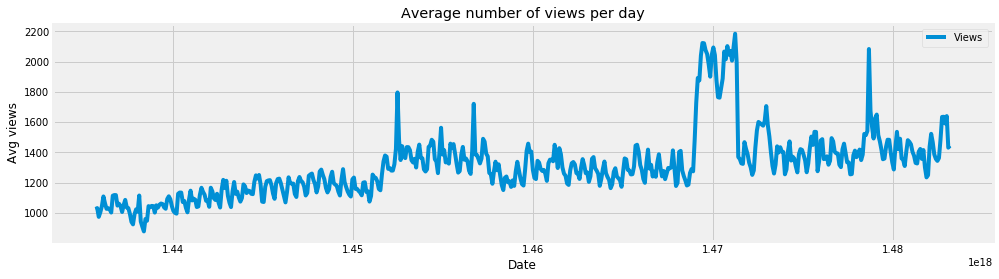

In [7]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

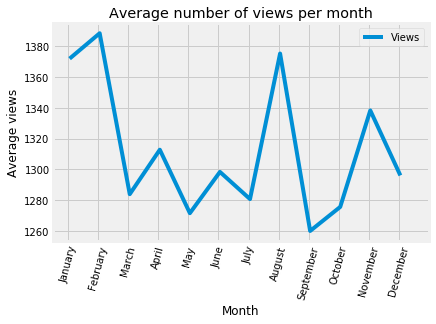

In [13]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [ ]:
weekday_index = df_reshaped.index.weekday_name
views_by_weekdays = df_reshaped.groupby(weekday_index).sum()

ax = views_by_weekdays.plot()
#start, end = ax.get_xlim()
#plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
#ax.set_xticklabels(months,rotation=75)
#ax.set_xlabel('Month')
ax.set_ylabel('Total views')
plt.show()

In [14]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
temp1 = df_reshaped  
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

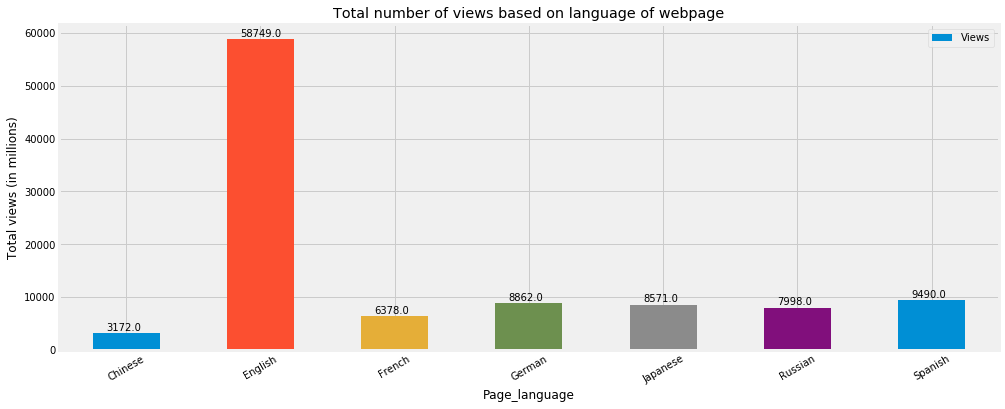

In [26]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
ax.legend()
plt.show()

In [ ]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [ ]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [8]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages.nlargest(5,'Views')

,Page,Views
58761,Main_Page_en.wikipedia.org_all-access_all-agents,1.206618e+10
58763,Main_Page_en.wikipedia.org_desktop_all-agents,8.774497e+09
58764,Main_Page_en.wikipedia.org_mobile-web_all-agents,3.153985e+09
93891,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,1.603934e+09
82337,Special:Search_en.wikipedia.org_all-access_all...,1.304079e+09


In [9]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(['Main_Page_en.wikipedia.org_all-access_all-agents','Main_Page_en.wikipedia.org_desktop_all-agents','Main_Page_en.wikipedia.org_mobile-web_all-agents','Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents','Special:Search_en.wikipedia.org_all-access_all-agents'])]

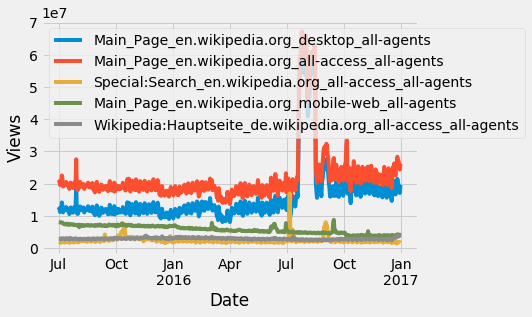

In [14]:
for i in list(top5_pages_df.Page.unique())[:5]:
    ax = top5_pages_df.loc[top5_pages_df.Page == i,:].Views.plot(label=i)
ax.set_ylabel('Views')
plt.legend(loc='upper left')
plt.show()

In [16]:
top5_pages_df.head()

,Page,Views
Date,,
2015-07-01,Main_Page_en.wikipedia.org_desktop_all-agents,11952559.0
2015-07-01,Main_Page_en.wikipedia.org_all-access_all-agents,20381245.0
2015-07-01,Special:Search_en.wikipedia.org_all-access_all...,2034850.0
2015-07-01,Main_Page_en.wikipedia.org_mobile-web_all-agents,8039732.0
2015-07-01,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2983623.0


In [17]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])

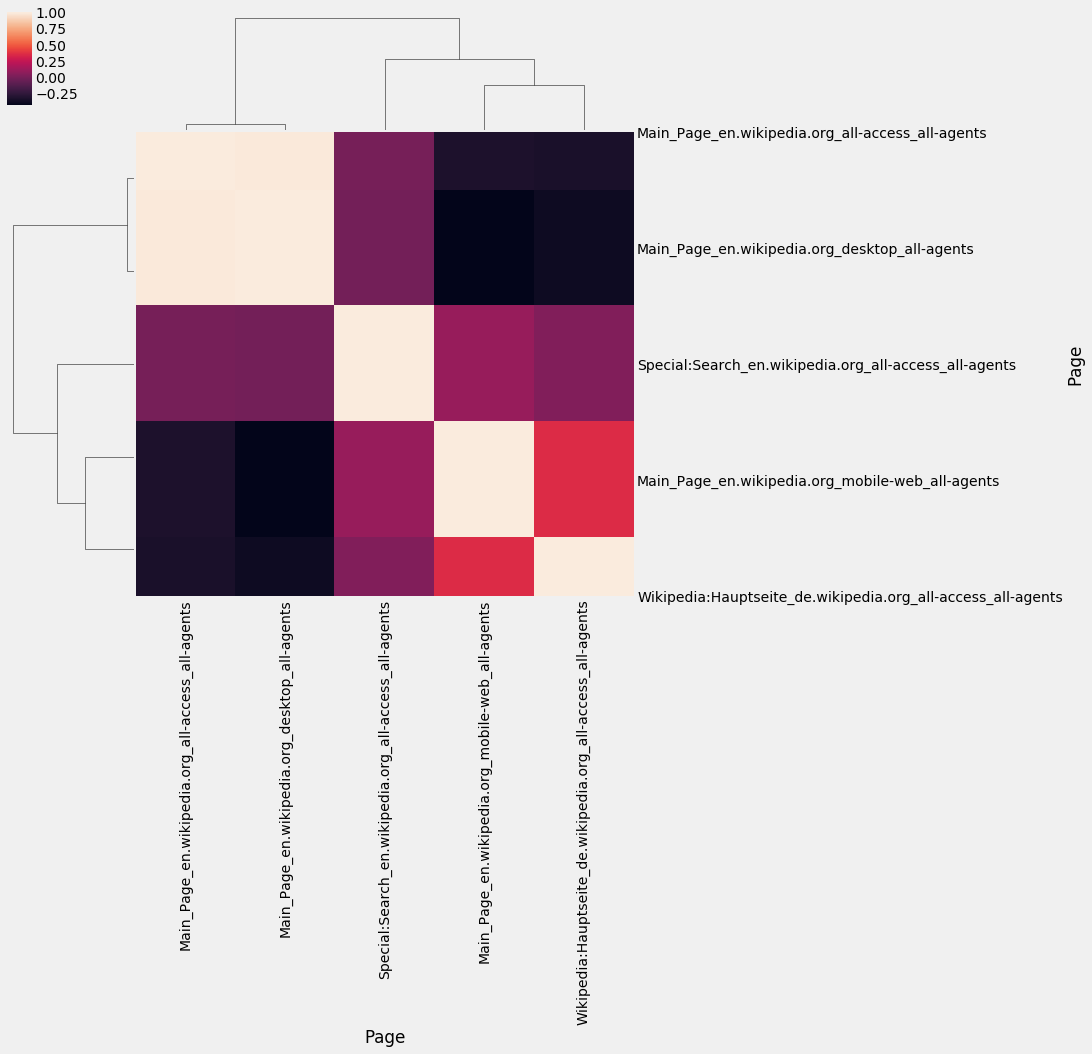

In [18]:
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [19]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df.head()

,Page,Views
Date,,
2015-07-01,Main_Page_en.wikipedia.org_all-access_all-agents,20381245.0
2015-07-02,Main_Page_en.wikipedia.org_all-access_all-agents,20752194.0
2015-07-03,Main_Page_en.wikipedia.org_all-access_all-agents,19573967.0
2015-07-04,Main_Page_en.wikipedia.org_all-access_all-agents,20439645.0
2015-07-05,Main_Page_en.wikipedia.org_all-access_all-agents,20772109.0


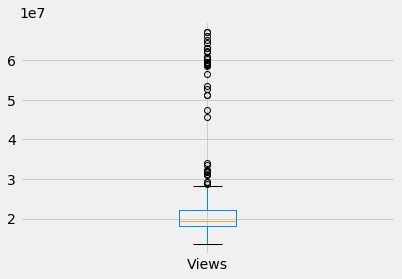

In [20]:
ax1 = top_page_df.boxplot()

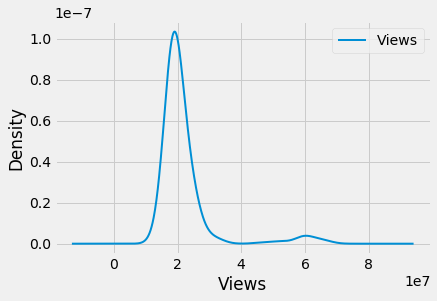

In [21]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

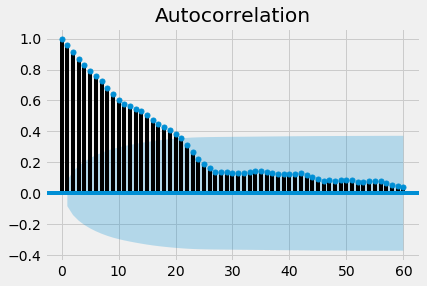

In [22]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

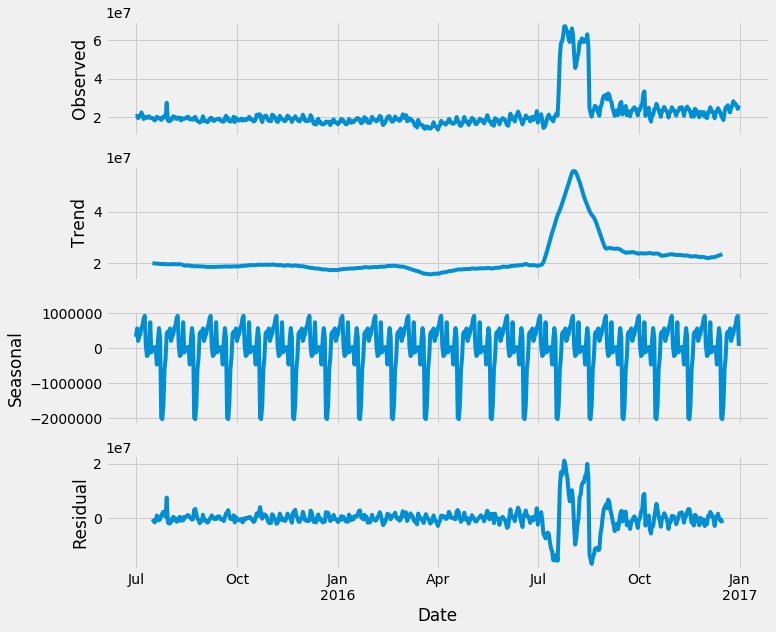

In [23]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df['Views'],freq = 30)
figure = ts_decomposition.plot()
plt.show()

## Augmented Dicky-Fuller test

In [24]:
test = adfuller(top_page_df['Views'])
print(test)

(-2.9901447422616267, 0.03582506369610538, 15, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 17078.891523280352)


 0th element is the test statistic. Since the value is approximately -3, we can say that the data is more likely to be stationary.
 1st element indicates the p-value. Since the p-value is < 0.05, we can reject null hypothesis.

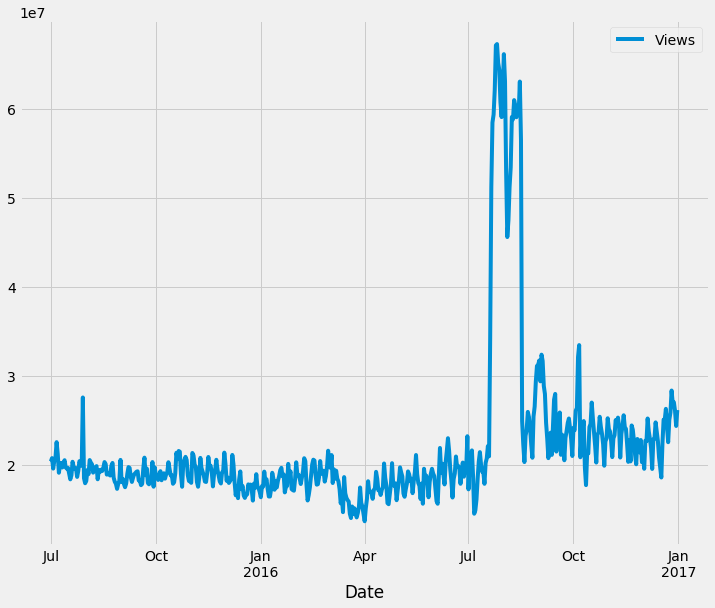

In [25]:
ax = top_page_df.plot()
plt.show()

In [26]:
top_page_filtered = top_page_df[['Views']]
stationary_df = top_page_filtered.diff().dropna()
stationary_df.head()

,Views
Date,
2015-07-02,370949.0
2015-07-03,-1178227.0
2015-07-04,865678.0
2015-07-05,332464.0
2015-07-06,1772560.0


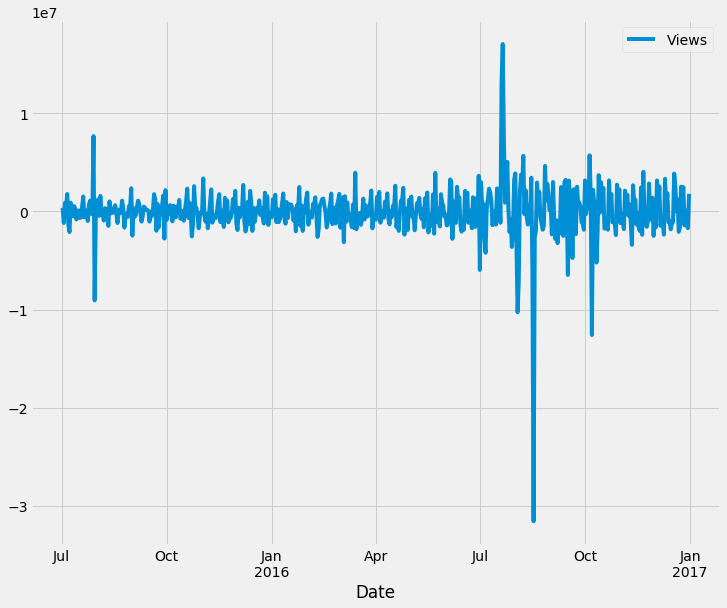

In [27]:
ax = stationary_df.plot()
plt.show()

In [28]:
test2 = adfuller(stationary_df['Views'])
print(test2)

(-6.6386055495935885, 5.481911439181468e-09, 14, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 17054.780239373413)


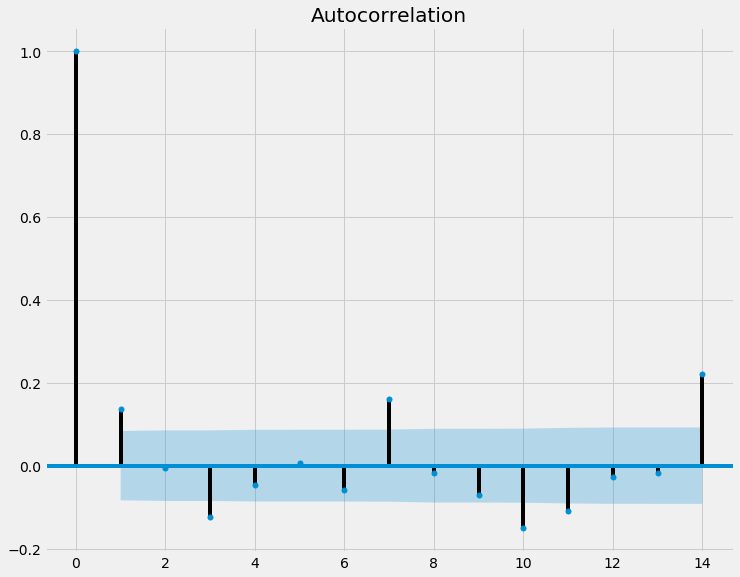

In [29]:
fig = tsaplots.plot_acf(stationary_df['Views'], lags=14)
plt.show()

## Modelling

In [64]:
train = top_page_filtered[:'2016-09']
test = top_page_filtered['2016-10':]

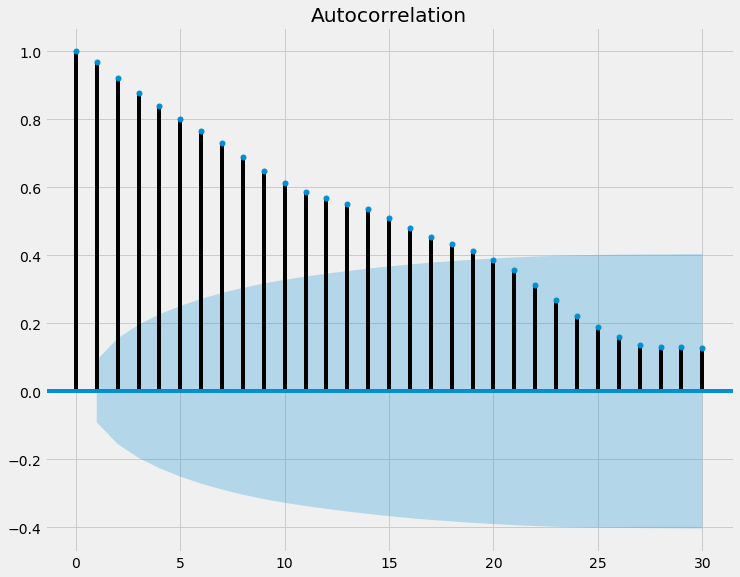

In [31]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

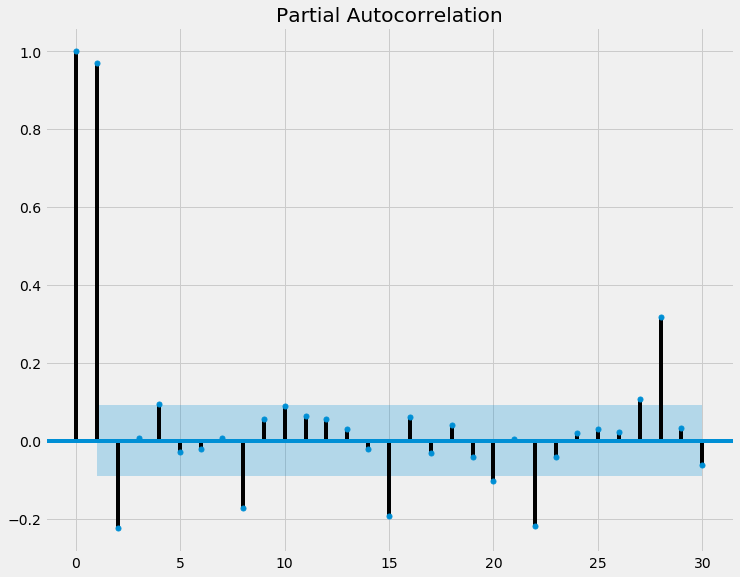

In [32]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

In [33]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
            print(p, q, result.aic, result.bic)
        except:
            print(p,q,None,None)


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueW

0 0 16859.00010687997 16863.126976064083
0 1 None None
0 2 None None
0 3 None None
0 4 None None
0 5 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0 6 None None
1 0 14807.702527176698 14815.956265544926


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 1 14792.572552218817 14804.95315977116


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 2 14793.233177982489 14809.740654718946


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 3 14790.291133578561 14810.925479499132
1 4 14792.313541257208 14817.074756361893


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 5 14794.411726878765 14823.299811167564


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1 6 14793.849593447057 14826.864546919971
2

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



 0 14792.086337241422 14804.466944793765


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 1 14793.951283352564 14810.45876008902


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 2 14793.610585767623 14814.244931688194


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 3 14792.534281654174 14817.29549675886


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 4 14792.726998400238 14821.615082689037


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 5 14796.443901308448 14829.458854781362


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2 6 14794.148078498223 14831.28990115525


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 0 14793.813483756048 14810.320960492505


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 1 14795.893017659622 14816.527363580193


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 2 14790.37794850681 14815.139163611495


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 3 14794.381758097432 14823.269842386231


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 4 14792.691315696786 14825.7062691697


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 5 14796.921524405036 14834.063347062063


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



3 6 14797.528824400993 14838.797516242135
4 0 14790.819647395858 14811.453993316429


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



4 1 14792.798856465235 14817.56007156992


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



4 2 14794.806427860283 14823.694512149083


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



4 3 14793.51138697442 14826.526340447333


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



4 4 14793.694217778459 14830.836040435486


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



4 5 14786.885487686723 14828.154179527864


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



4 6 14783.774700030768 14829.170261056024
5 0 14792.803266710784 14817.564481815469


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



5 1 14794.797878449062 14823.685962737862


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



5 2 14792.696862817644 14825.711816290557
5 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



5 4 14785.682102743413 14826.950794584554
5 5 14782.822766487483 14828.218327512739


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



5 6 14774.339992840534 14823.862423049904
6 0 14794.795705465396 14823.683789754195


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



6 1 14795.059344962307 14828.07429843522


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



6 2 14768.298740128015 14805.440562785043
6 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



6 4 14782.893820676261 14828.289381701517
6 5 None None
6 6 14762.650358427061 14816.299657820546


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [34]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
print(aic_bic_df.sort_values('aic'))

    p  q           aic           bic
39  6  6  14762.650358  14816.299658
37  6  2  14768.298740  14805.440563
34  5  6  14774.339993  14823.862423
33  5  5  14782.822766  14828.218328
38  6  4  14782.893821  14828.289382
28  4  6  14783.774700  14829.170261
32  5  4  14785.682103  14826.950795
27  4  5  14786.885488  14828.154180
4   1  3  14790.291134  14810.925479
17  3  2  14790.377949  14815.139164
22  4  0  14790.819647  14811.453993
8   2  0  14792.086337  14804.466945
5   1  4  14792.313541  14817.074756
11  2  3  14792.534282  14817.295497
2   1  1  14792.572552  14804.953160
19  3  4  14792.691316  14825.706269
31  5  2  14792.696863  14825.711816
12  2  4  14792.726998  14821.615083
23  4  1  14792.798856  14817.560072
29  5  0  14792.803267  14817.564482
3   1  2  14793.233178  14809.740655
25  4  3  14793.511387  14826.526340
10  2  2  14793.610586  14814.244932
26  4  4  14793.694218  14830.836040
15  3  0  14793.813484  14810.320960
7   1  6  14793.849593  14826.864547
9

## Fitting ARMA model

In [35]:
model = SARIMAX(train,order=(6,0,2))
result = model.fit()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [36]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean

In [37]:
forecast_mean.head()

2016-09-01    3.198649e+07
2016-09-02    3.011212e+07
2016-09-03    3.055111e+07
2016-09-04    3.165442e+07
2016-09-05    3.254134e+07
Freq: D, dtype: float64

In [38]:
confidence_interval = forecast.conf_int()
confidence_interval.head()

,lower Views,upper Views
2016-09-01,2.715197e+07,3.682100e+07
2016-09-02,2.527761e+07,3.494662e+07
2016-09-03,2.571662e+07,3.538561e+07
2016-09-04,2.681992e+07,3.648891e+07
2016-09-05,2.770684e+07,3.737583e+07


## Predicting the number of views for the last 30 days using ARMA model

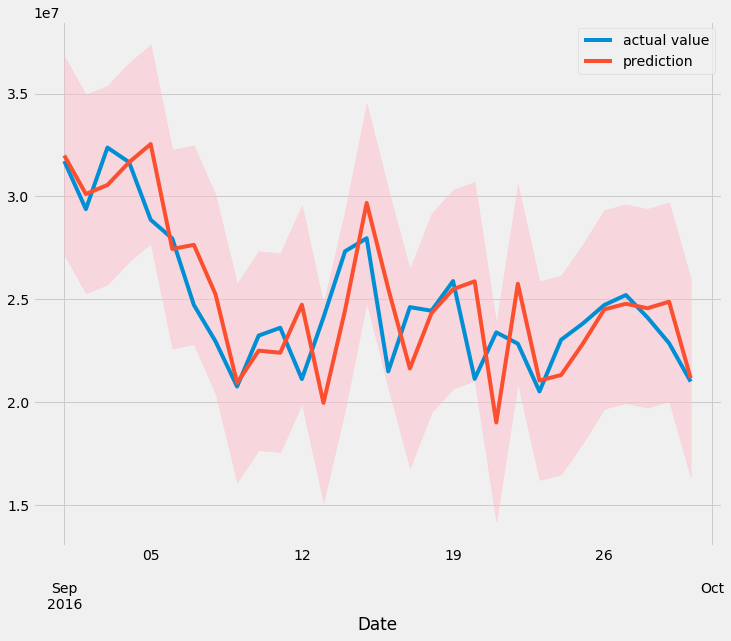

In [39]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

### Forecasting using ARMA model

In [40]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

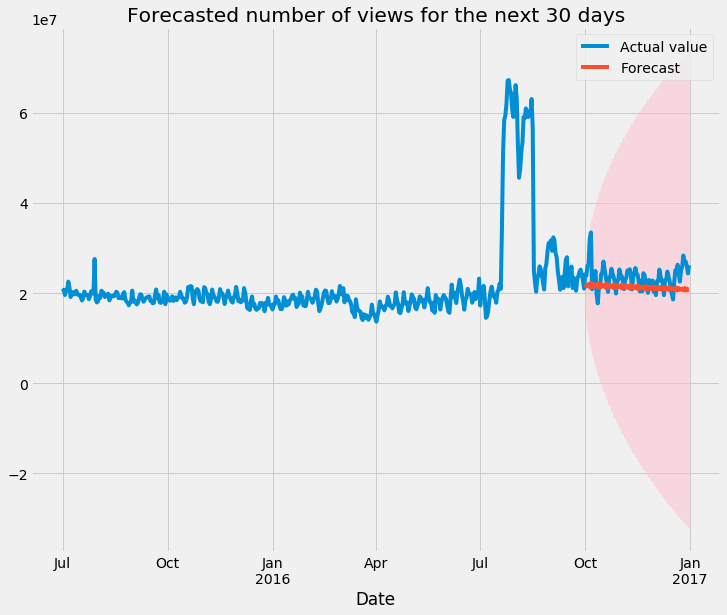

In [41]:
fig,ax=plt.subplots()
top_page_filtered.rename(columns={'Views':'Actual value'}).plot(ax=ax)
forecast_values_mean.plot(ax=ax,label='Forecast')
plt.fill_between(conf_interval.index, \
                conf_interval['lower Views'], \
                conf_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [42]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

RMSE: 3289770.2459289175


## ARIMA model

In [43]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
print(arima_aic_bic_df.sort_values('aic'))

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No f

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was pr

    p  q           aic           bic
36  5  6  14720.964048  14770.460248
39  6  2  14731.498355  14768.620506
34  5  4  14744.786649  14786.033483
15  2  2  14746.873278  14767.496694
25  3  5  14747.091233  14784.213384
29  4  4  14748.151291  14785.273441
30  4  5  14750.339926  14791.586760
41  6  6  14750.677039  14804.297923
23  3  3  14751.977302  14780.850086
35  5  5  14752.531163  14797.902680
24  3  4  14753.083650  14786.081117
26  3  6  14753.087659  14794.334493
40  6  5  14754.203279  14803.699480
31  4  6  14754.627680  14799.999197
19  2  6  14756.277045  14793.399196
3   0  3  14756.334775  14772.833508
20  3  0  14756.600959  14773.099693
1   0  1  14757.078436  14765.327803
7   1  0  14757.160982  14765.410349
10  1  3  14758.237780  14778.861197
4   0  4  14758.287809  14778.911226
18  2  5  14758.409916  14791.407383
27  4  0  14758.593891  14779.217308
21  3  1  14758.595458  14779.218875
14  2  0  14758.600459  14770.974510
11  1  4  14758.658471  14783.406571
2

In [44]:
arima_model = SARIMAX(train,order=(5,1,6))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



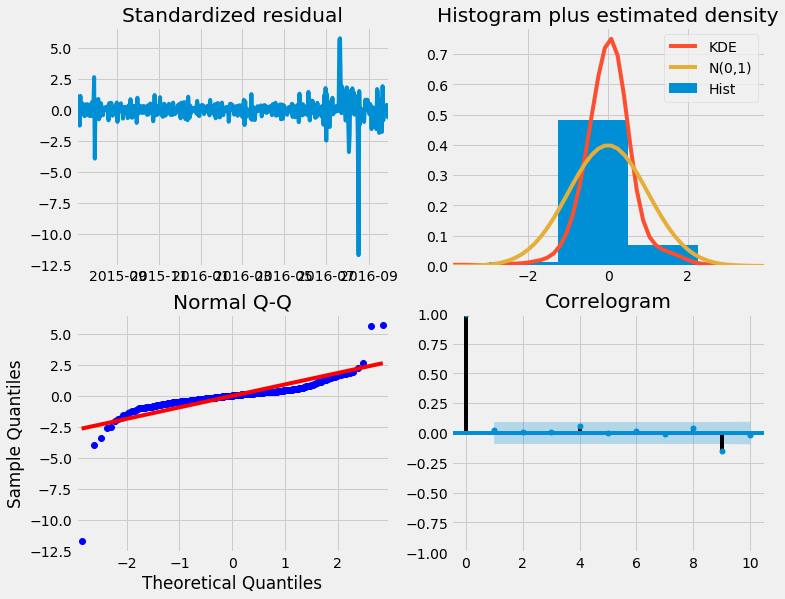

In [85]:
arima_result.plot_diagnostics()
plt.show()

In [83]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(5, 1, 6)   Log Likelihood               -7348.482
Date:                Mon, 18 May 2020   AIC                          14720.964
Time:                        18:46:57   BIC                          14770.460
Sample:                    07-01-2015   HQIC                         14740.460
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2828      0.168      1.679      0.093      -0.047       0.613
ar.L2          0.6806      0.095      7.190      0.000       0.495       0.866
ar.L3         -0.7462      0.043    -17.440      0.000      -0.830      -0.662
ar.L4         -0.5286      0.090     -5.855      0.000      -0.706      -0.352
ar.L5          0.8213      0.165      4.982      0.000       0.498       1.144
ma.L1         -0.0784      0.175     -0.448      0.654      -0.421       0.264
ma.L2         -0.7534      0.127     -5.953      0.000      -1.001      -0.505
ma.L3          0.5428      0.083      6.532      0.000       0.380       0.706
ma.L4          0.6989      0.088      7.952      0.000       0.527       0.871
ma.L5         -0.7163      0.165     -4.340      0.000      -1.040      -0.393
ma.L6         -0.2340      0.038     -6.149      0.000      -0.309      -0.159
sigma2       6.18e+12    3.8e-14   1.63e+26      0.000    6.18e+12    6.18e+12
===================================================================================
Ljung-Box (Q):                       86.39   Jarque-Bera (JB):             74517.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.98   Skew:                            -3.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.92e+41. Standard errors may be unstable.
"""

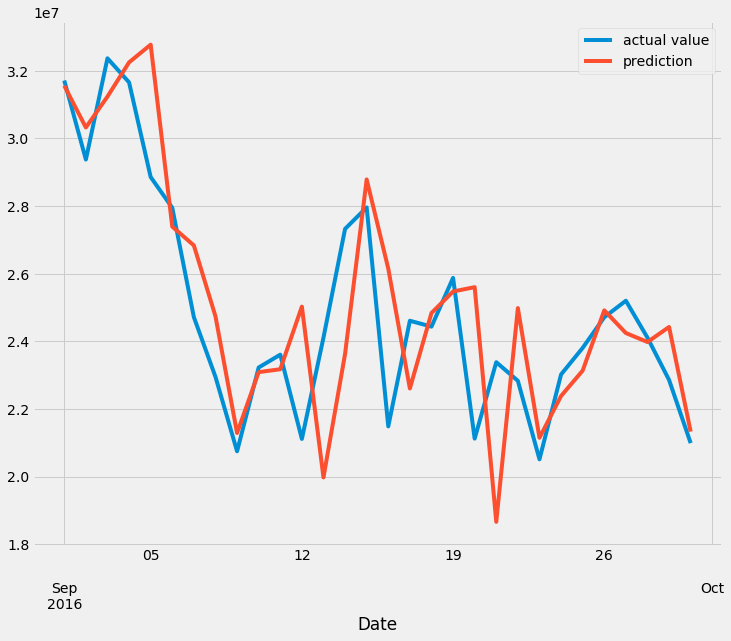

In [45]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

### Forecasting using ARIMA model

In [46]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

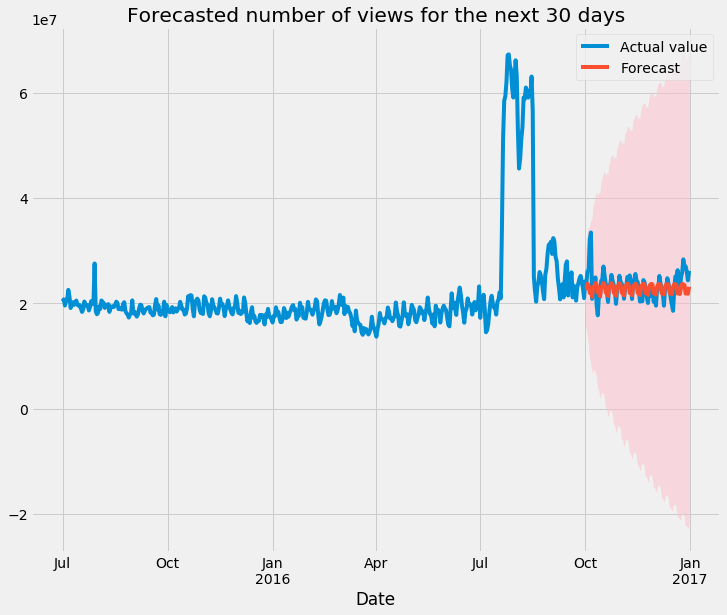

In [47]:
fig,ax=plt.subplots()
top_page_filtered.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arima_forecast_mean.plot(ax=ax,label='Forecast')
plt.fill_between(arima_conf_interval.index, \
                arima_conf_interval['lower Views'], \
                arima_conf_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [48]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(arima_forecast_mean.values - test.Views.values)))))

RMSE: 2429628.472515125


## Exponential smoothing model

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



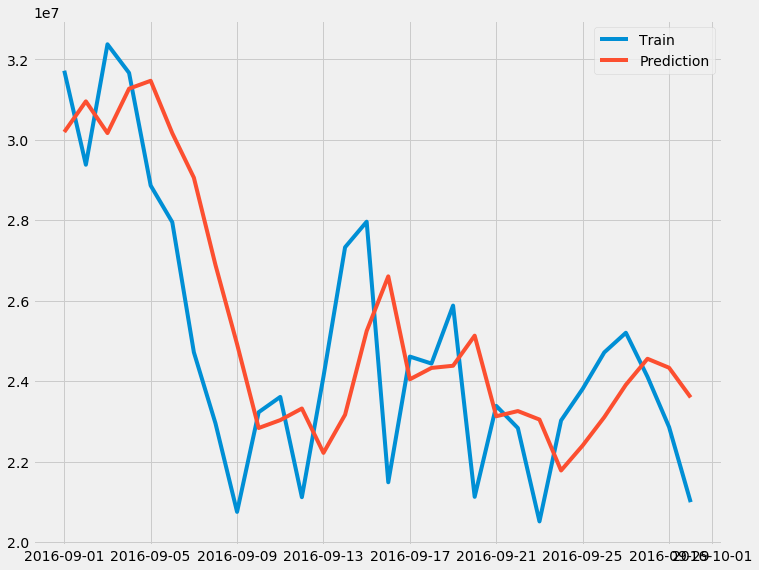

In [49]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])
plt.plot(train[-30:], label='Train')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

### Forecasting using Exponential Smoothing model

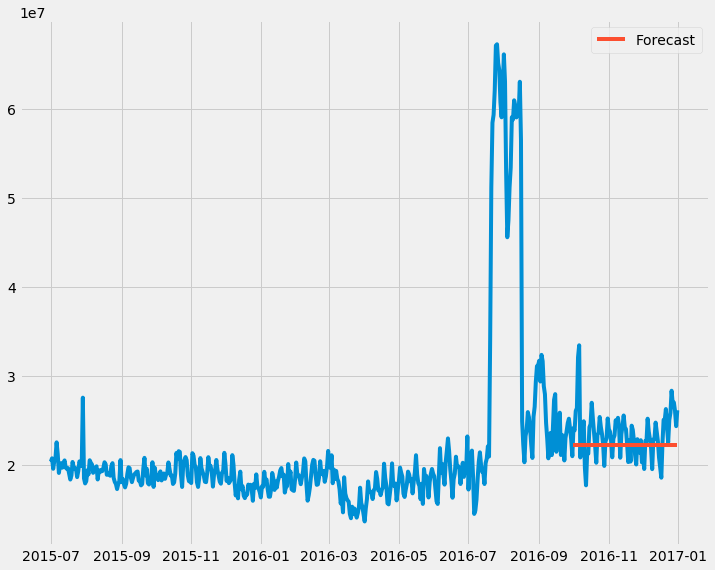

In [50]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])
plt.plot(top_page_filtered)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [51]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))

RMSE: 2745707.736515956


## Prophet

In [118]:
prophet_model = Prophet()
prophet_result = prophet_model.fit(train.reset_index().rename(columns={'Date':'ds','Views':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [120]:
future = prophet_model.make_future_dataframe(periods=test.shape[0])
forecast = prophet_model.predict(future)

In [121]:
train.shape[0]

458

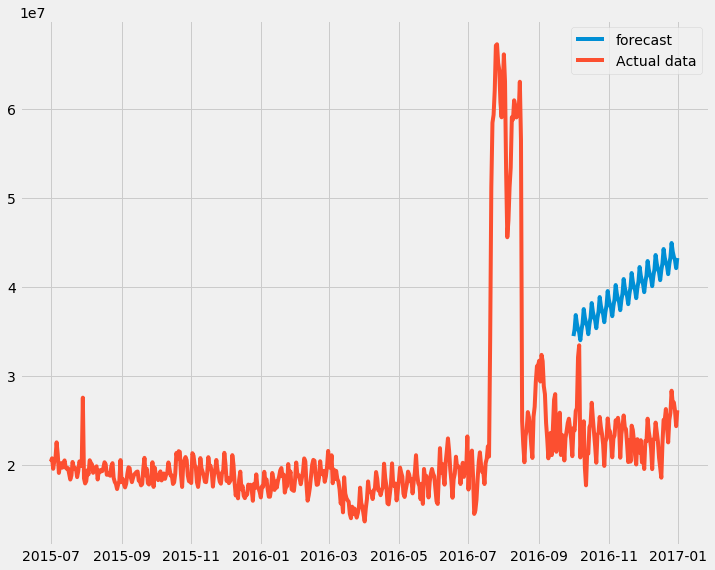

In [122]:
prophet_forecast = forecast[['ds','yhat_lower','yhat_upper','yhat']][-test.shape[0]:]
plt.plot(prophet_forecast['ds'],prophet_forecast['yhat'],label='forecast')
plt.plot(top_page_filtered, label='Actual data')
# plt.fill_between(prophet_forecast['ds'],prophet_forecast['yhat_lower'],prophet_forecast['yhat_upper'])
plt.legend(loc='best')
plt.show()

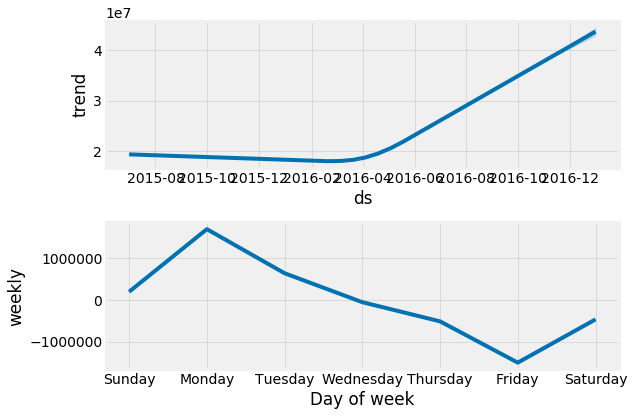

In [90]:
fig = prophet_model.plot_components(forecast)

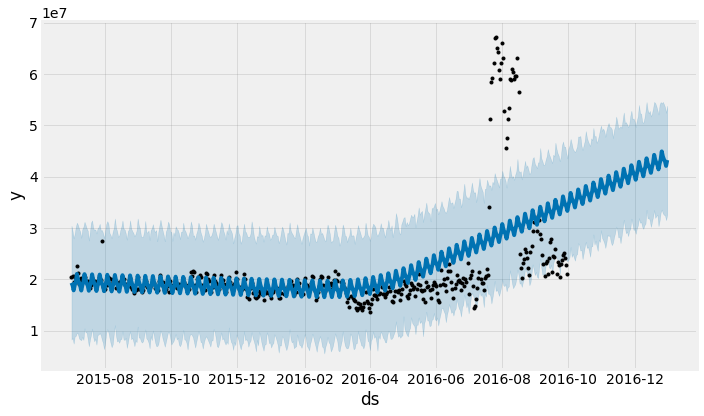

In [91]:
fig1 = prophet_model.plot(forecast)